In [35]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt
import numpy as np
import sys
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [32]:
plt.rcParams["figure.figsize"] = (15, 10)

# Set font sizes
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'legend.fontsize': 22})

# Set linewidth and styles
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.linestyle'] = '-'

# Set directions of the ticks
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Set sizes of the major and minor ticks
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 5

# Set the width of the ticks
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

# Disable grid if preferred
plt.rcParams['axes.grid'] = False
plt.rcParams.update({'figure.max_open_warning': 0})

# Adjust the padding of the colorbar to fit within the figure
plt.rcParams['axes.titlepad'] = 20  # Space above the title

# Set the font weight if necessary
plt.rcParams['axes.labelweight'] = 'bold'

# You can also specify the edge color of the axes if needed
plt.rcParams['axes.edgecolor'] = 'black'

# Disable the display of the top and right spines if you prefer that style
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [13]:
class ReflectionPadding3D(Layer):
    def __init__(self, padding=(1,1,1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding3D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3] + 2 * self.padding[2], s[4])

    def call(self, x):
        padding_width = [[0, 0], [self.padding[0], self.padding[0]], [self.padding[1], self.padding[1]], [self.padding[2], self.padding[2]], [0, 0]]
        return tf.pad(x, padding_width, mode='REFLECT')

    def get_config(self):
        config = super(ReflectionPadding3D, self).get_config()
        config.update({
            'padding': self.padding
        })
        return config
    
def conv_block(input_tensor, num_filters, kernel_size, padding=(1,1,1),batch_norm=True, final_activation='relu'):
    x = ReflectionPadding3D(padding=padding)(input_tensor)
    x = Conv3D(num_filters, kernel_size, padding='valid')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(final_activation)(x)
    return x

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters, kernel_size=(5, 5, 5),padding=(2,2,2), batch_norm=(num_filters != 32))
    pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(encoder)
    return pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = UpSampling3D((2, 2, 2))(input_tensor)
    decoder = concatenate([concat_tensor, decoder], axis=-1)
    decoder = conv_block(decoder, num_filters, kernel_size=(3, 3, 3), padding=(1,1,1),final_activation='relu')
    return decoder


In [14]:
a = np.load("/home/scratch/SDCunist/3d_DL/Train_sets/SDC3_REAL.npy")
print(a.shape)

(100, 128, 128, 128)


In [15]:
model_path = "/home/scratch/SDCunist/3d_DL/0311_3dmodel.h5"
gpu=False
if gpu:
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    with tf.device(gpus)
        try:
            loaded_model = load_model(model_path,custom_objects={'ReflectionPadding3D': ReflectionPadding3D})
        except OSError as e:
            print(f"Error loading model: {e}")
            exit(1)
        try:
            prediction = loaded_model(a[:4]).numpy()  # Adjust the slice as per your batch size
        except Exception as e:
            print(f"Error during prediction: {e}")
            exit(1)
    
else:
    with tf.device('/CPU:0'):
        try:
            loaded_model = load_model(model_path,custom_objects={'ReflectionPadding3D': ReflectionPadding3D})
        except OSError as e:
            print(f"Error loading model: {e}")
            exit(1)
        try:
            prediction = loaded_model(a[:4]).numpy()  # Adjust the slice as per your batch size
        except Exception as e:
            print(f"Error during prediction: {e}")
            exit(1)

In [16]:
# Save predictions
#output_path = "/home/scratch/SDCunist/3d_DL/Train_sets/result.npy"
#try:
#    np.save(output_path, prediction)
#except Exception as e:
#    print(f"Error saving predictions: {e}")
#    exit(1)

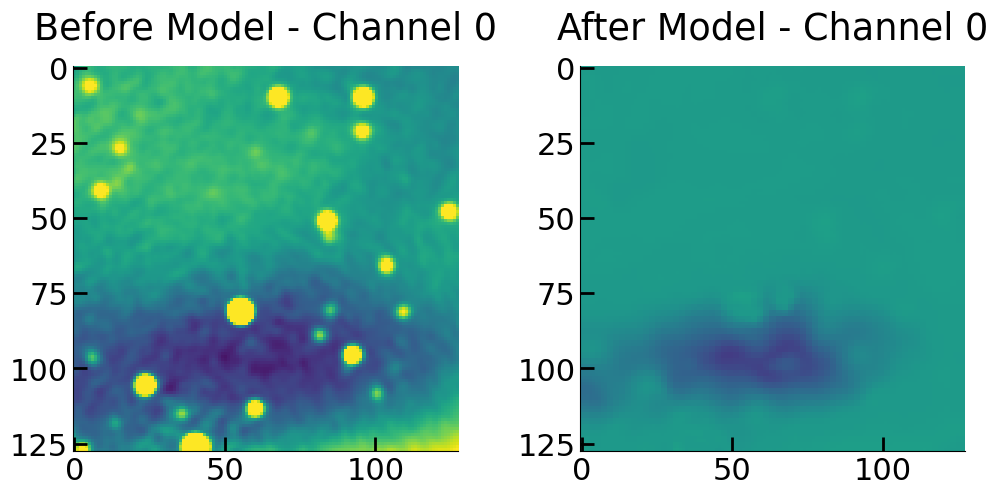

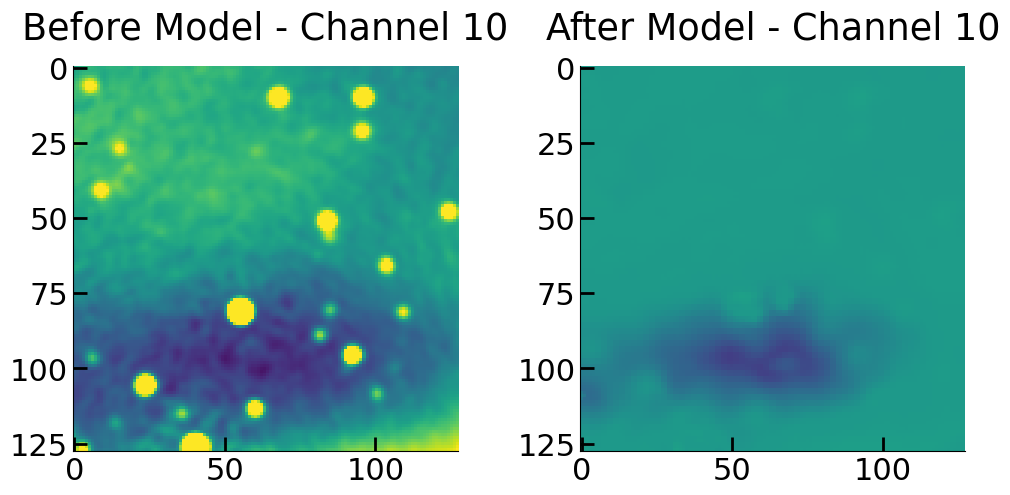

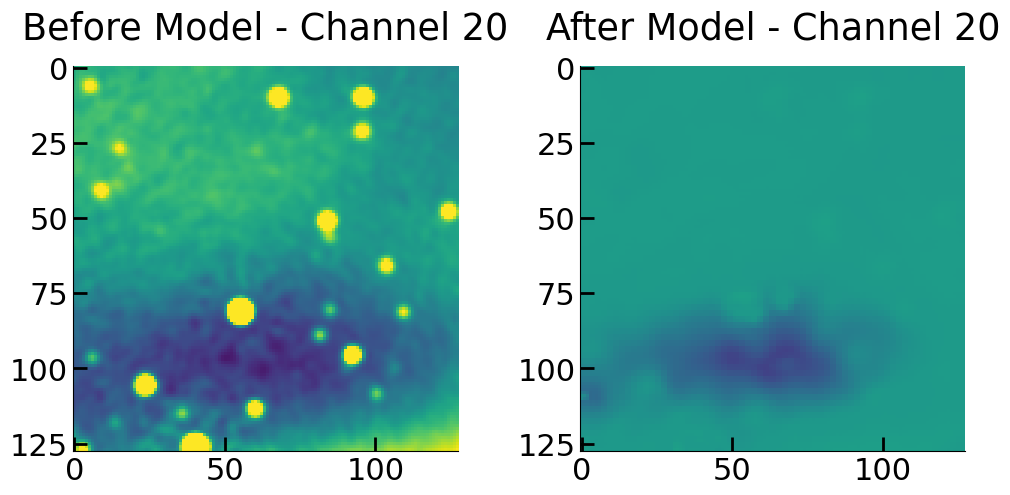

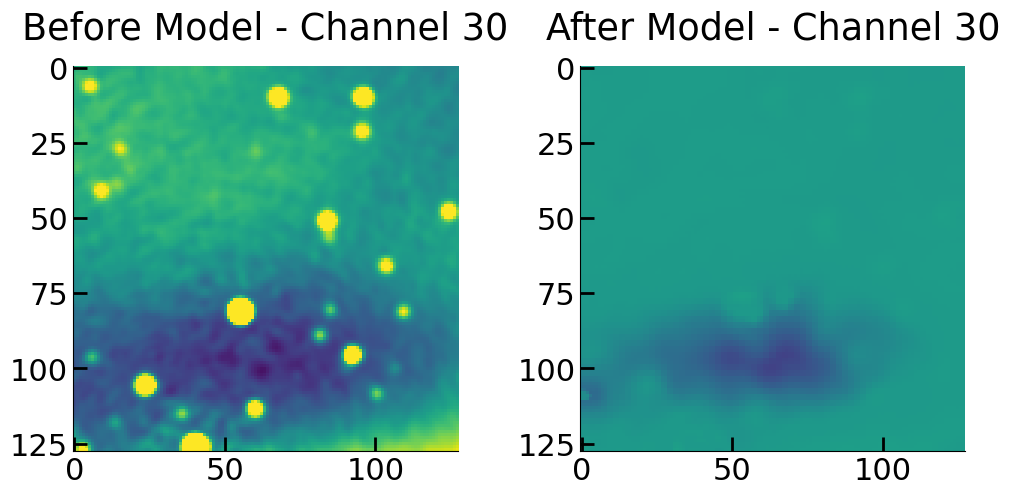

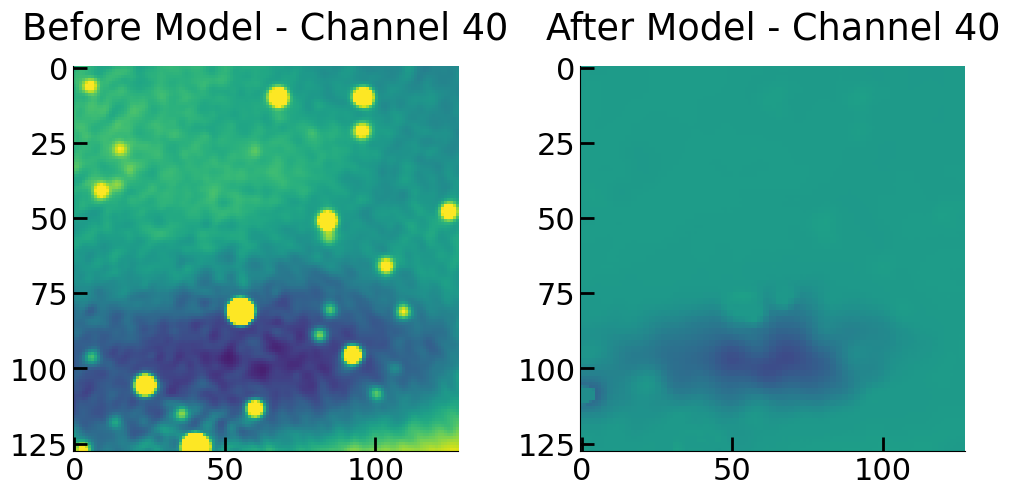

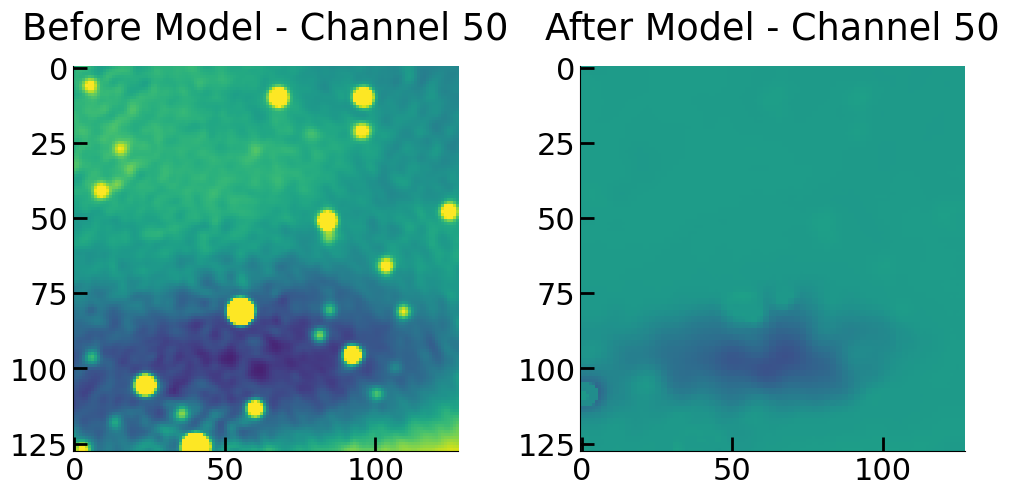

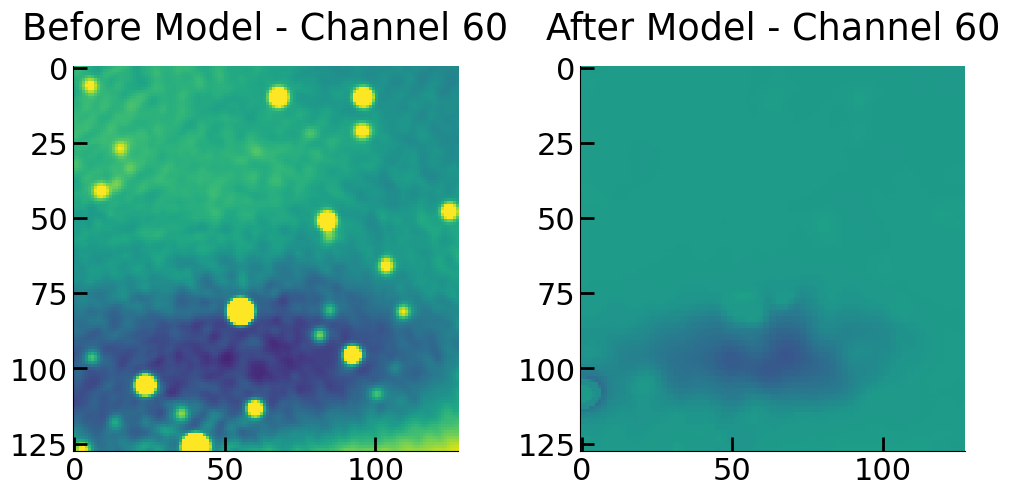

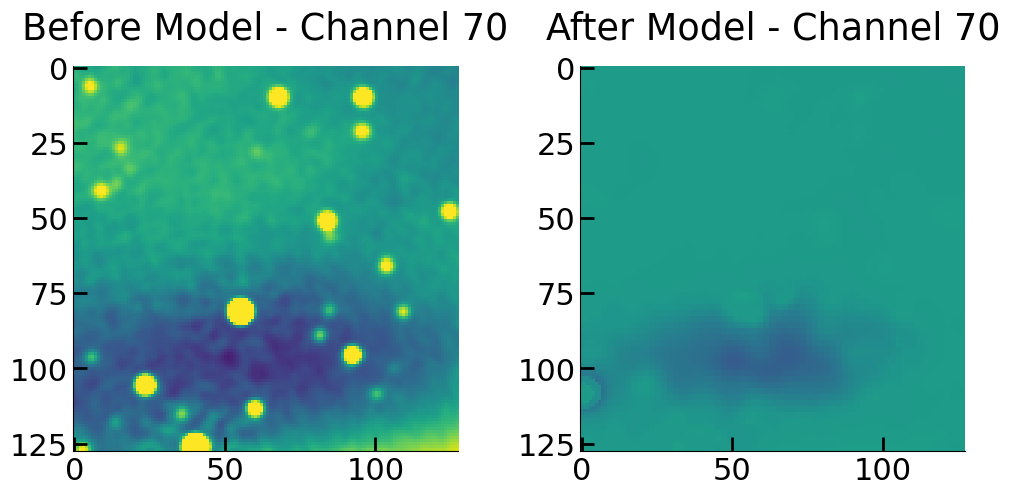

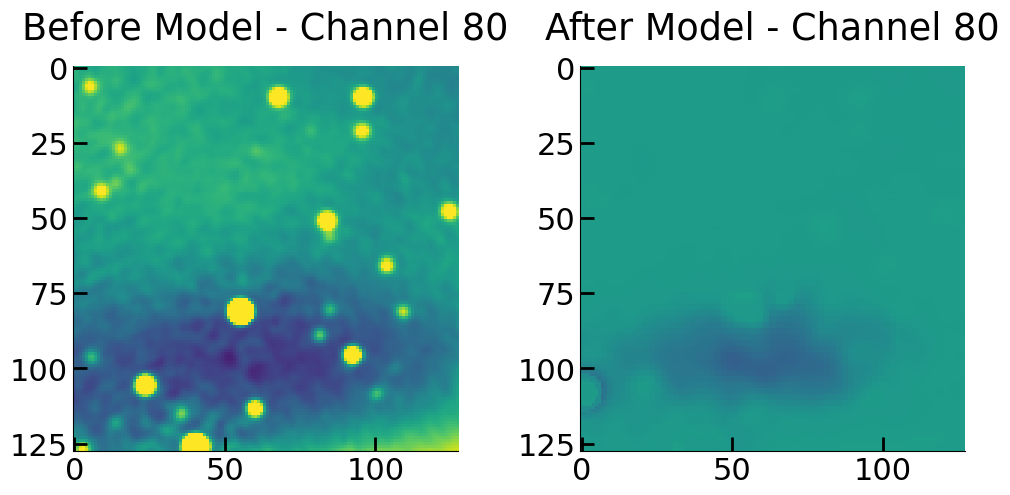

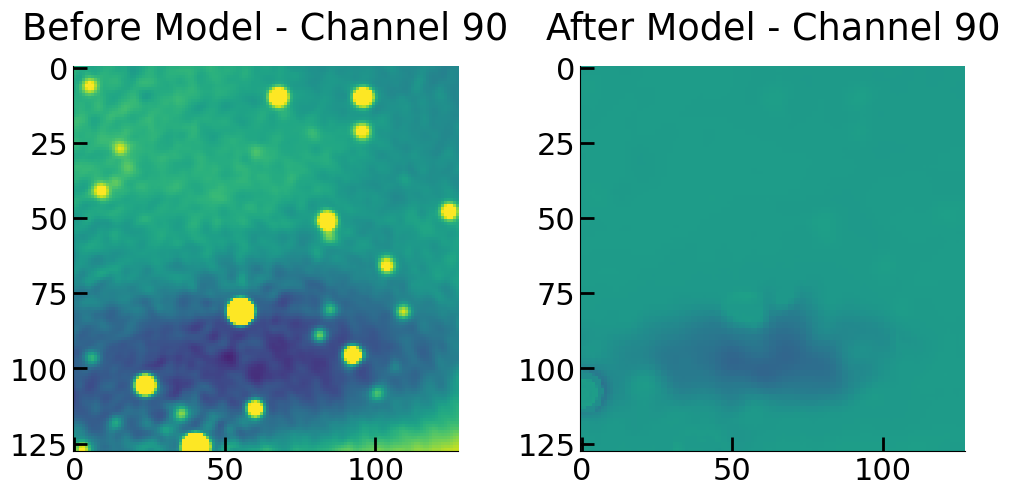

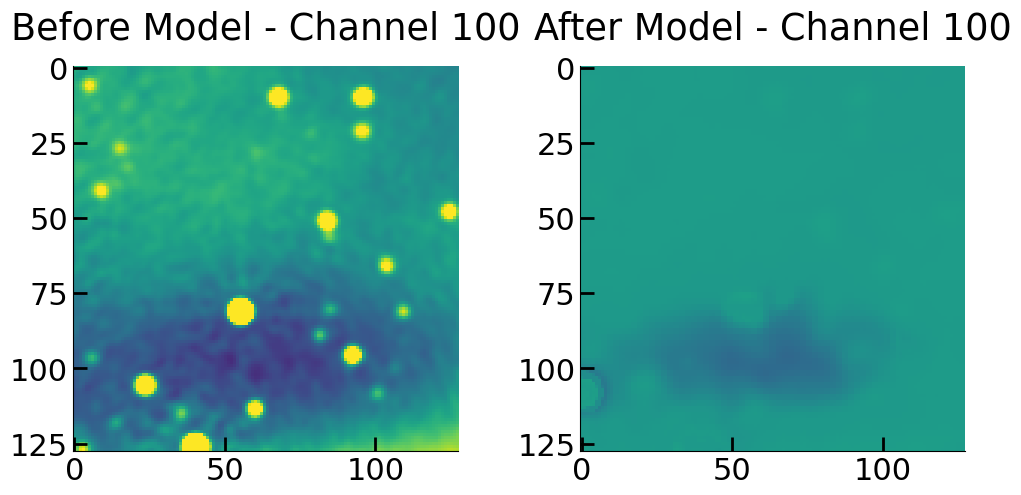

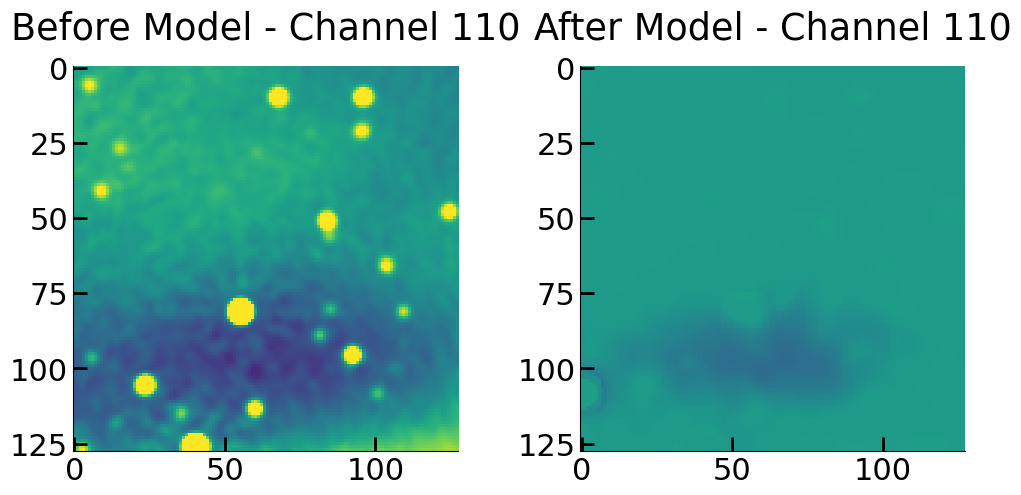

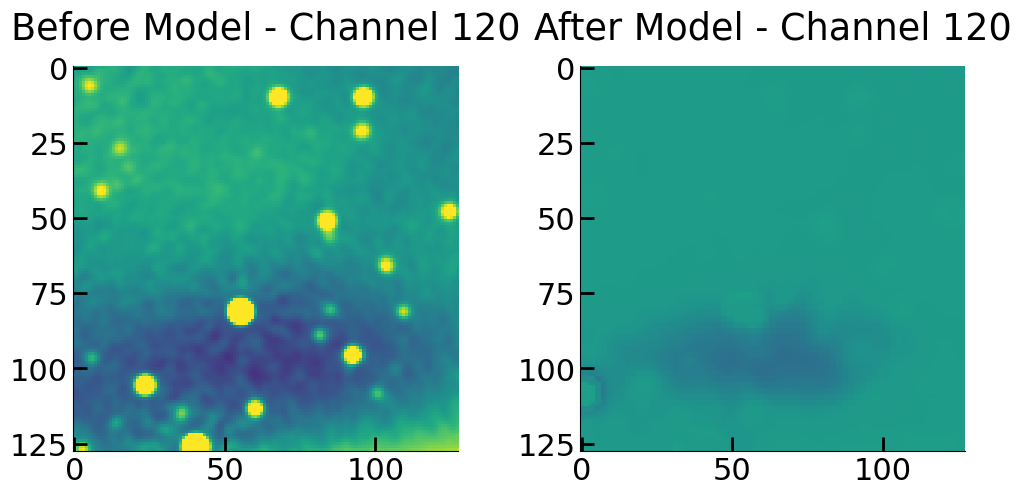

In [45]:
number=1
for i in range(0,128,10):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    im0 = axs[0].imshow(a[number, :, :, i], cmap='viridis',vmin=-0.005, vmax=0.005)
    axs[0].set_title(f'Before Model - Channel {i}')
    im1 = axs[1].imshow(prediction[number, :, :, i], cmap='viridis',vmin=-0.005, vmax=0.005)
    axs[1].set_title(f'After Model - Channel {i}')

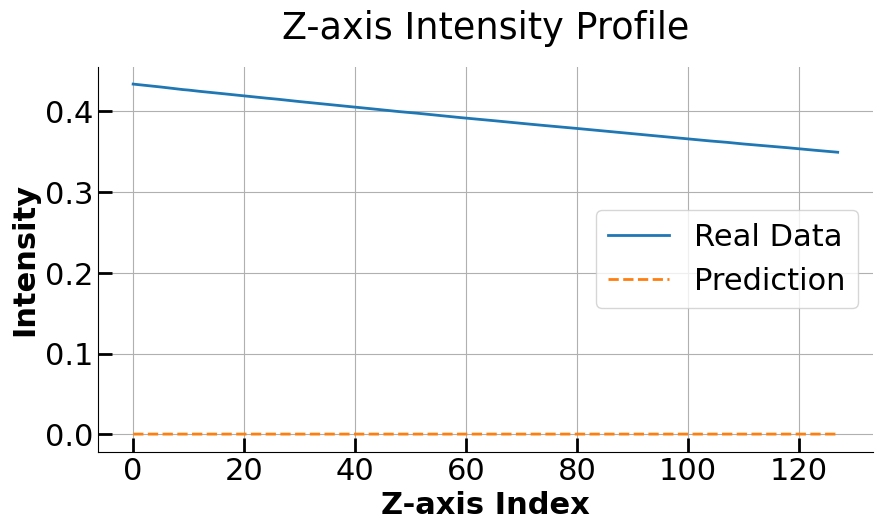

In [43]:
max_pos = np.unravel_index(np.argmax(a[number]), a.shape)

# Extract the z-axis profile for the brightest spot
z_profile_a = a[1,max_pos[1], max_pos[2], :]

# Assuming that the prediction data has the same shape and the brightest point corresponds to the same position
z_profile_prediction = prediction[1,max_pos[1], max_pos[2], :]

# Now plot both profiles
plt.figure(figsize=(10, 5))
plt.plot(z_profile_a, label='Real Data', linewidth=2)
plt.plot(z_profile_prediction, label='Prediction', linewidth=2, linestyle='--')
plt.title('Z-axis Intensity Profile')
plt.xlabel('Z-axis Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

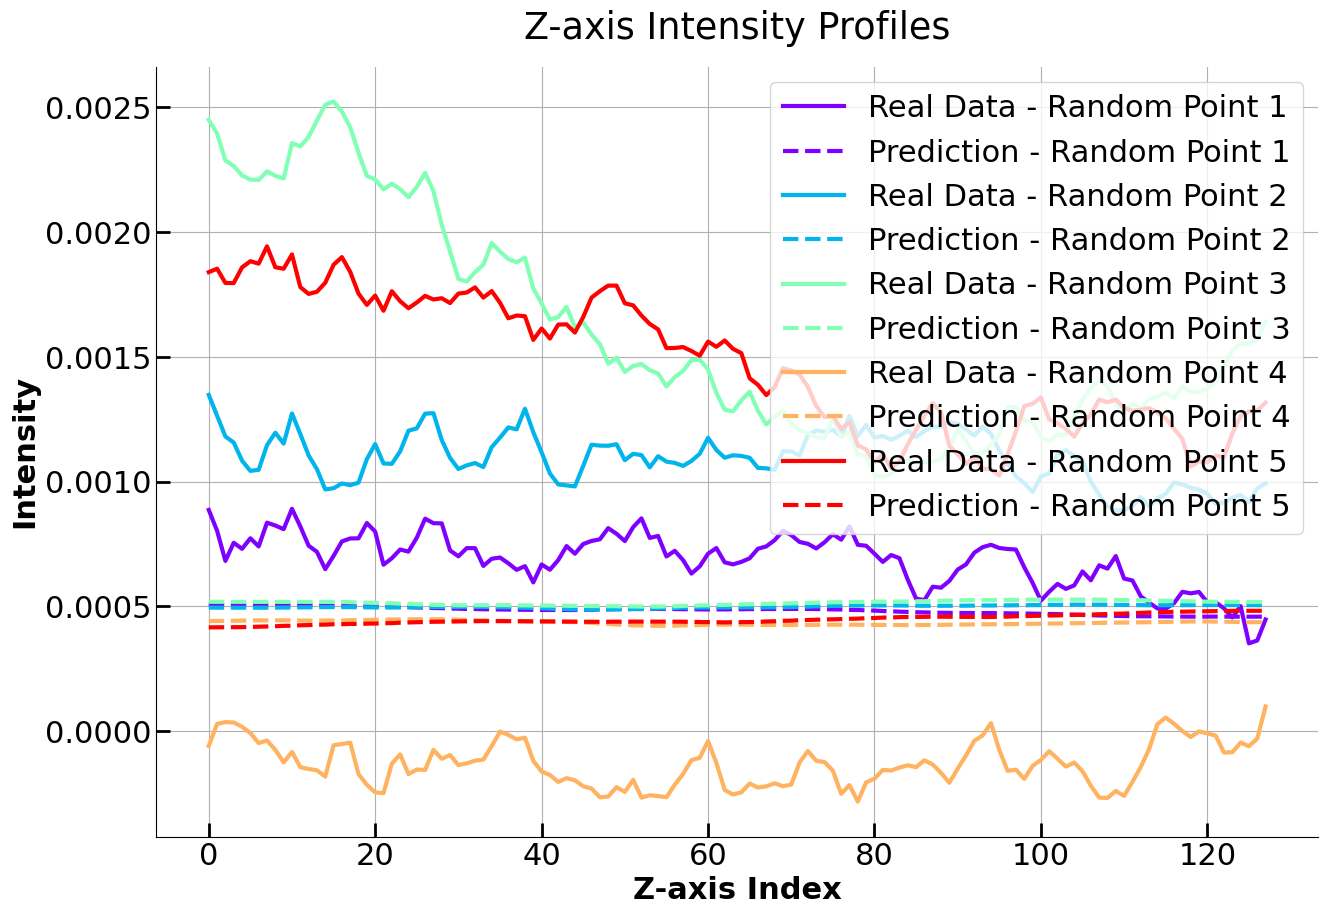

In [44]:
num_random_points = 5
colors = cm.rainbow(np.linspace(0, 1, num_random_points))

for i in range(num_random_points):
    random_x = np.random.randint(0, a.shape[0])
    random_y = np.random.randint(0, a.shape[1])
    z_profile_a = a[1,random_x, random_y, :]
    z_profile_prediction = prediction[1,random_x, random_y, :]
    color=colors[i]
    plt.plot(z_profile_a, label=f'Real Data - Random Point {i+1}',color=color, linewidth=3)
    plt.plot(z_profile_prediction, label=f'Prediction - Random Point {i+1}',color=color, linewidth=3, linestyle='--')

plt.title('Z-axis Intensity Profiles')
plt.xlabel('Z-axis Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()